# Difussion equation

Solving the poisson equation $u_t-\Delta u = f$ using a physics informed neural network in multi dim.

### Manufactured solution


We use $u = t\sin (x+y)$ for $x \in X_1\times X_2$, $t\in[t_1,t_2]$ to manufacture the rhs of the difussion equation above.

### Importing packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Manufacturing data for trainig

In [121]:
np.random.seed(123)
pde_data_size = 10000

#domain range
X_1_domain = [-2, 2]
X_2_domain = [0, 1]
#time range
T_initial = 0
T_final = 1

#space data
space_dim = 2
X_1_tr_pde = np.random.uniform(X_1_domain[0], X_1_domain[1], pde_data_size).reshape(pde_data_size,1)
X_2_tr_pde = np.random.uniform(X_2_domain[0], X_2_domain[1], pde_data_size).reshape(pde_data_size,1)
# X_tr_pde = np.random.uniform(-1,1,pde_data_size*space_dim).reshape(pde_data_size,space_dim)

#temporal data
X_tr_time = np.random.uniform(T_initial, T_final, pde_data_size).reshape(pde_data_size,1)

X_tr_pde = np.concatenate([X_1_tr_pde, X_2_tr_pde, X_tr_time],axis=1)
X_1_tr_pde.shape

(10000, 1)

In [122]:
X_tr_pde.shape

(10000, 3)

### Looking at the scatter plot of data

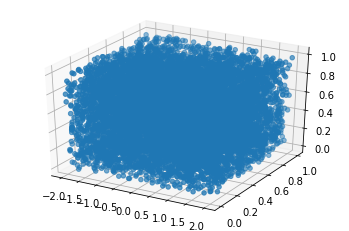

In [123]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tr_pde[:,0],X_tr_pde[:,1],X_tr_pde[:,2])


### Defining the labels(true values) for the training data

In [124]:
Y_tr_pde = np.zeros((X_tr_pde.shape[0],1))
# Y_tr_pde = X_tr_pde[:,0:1]


In [125]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((Y_tr_pde.shape[0],1))],axis=1)
Y_tr_pde.shape

(10000, 2)

## BC data 

In [126]:
bc_data_size = 1000

X_bc_left = np.random.uniform(X_2_domain[0],X_2_domain[1],
                              bc_data_size).reshape(bc_data_size,1)
X_bc_left = np.concatenate([X_1_domain[0]*np.ones((bc_data_size,1)),
                            X_bc_left], axis=1)
X_bc_left = np.concatenate([X_bc_left,
                            np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], 
                            axis=1)

X_bc_bottom = np.random.uniform(X_1_domain[0],X_1_domain[1],
                                bc_data_size).reshape(bc_data_size,1)
X_bc_bottom = np.concatenate([X_2_domain[0]*np.ones((bc_data_size,1)),
                            X_bc_bottom], axis=1)
X_bc_bottom = np.concatenate([X_bc_bottom,
                              np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], axis=1)

X_bc_right = np.random.uniform(X_2_domain[0],X_2_domain[1],
                              bc_data_size).reshape(bc_data_size,1)
X_bc_right = np.concatenate([X_1_domain[1]*np.ones((bc_data_size,1)),
                            X_bc_right], axis=1)
X_bc_right = np.concatenate([X_bc_right,
                            np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], 
                            axis=1)

X_bc_top = np.random.uniform(X_1_domain[0],X_1_domain[1],
                                bc_data_size).reshape(bc_data_size,1)
X_bc_top = np.concatenate([X_2_domain[1]*np.ones((bc_data_size,1)),
                            X_bc_top], axis=1)
X_bc_top = np.concatenate([X_bc_top,
                            np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], 
                            axis=1)

X_bc = np.concatenate([X_bc_left, X_bc_right, X_bc_bottom, X_bc_top],axis=0)

In [127]:
Y_bc = np.sin(X_bc[:,0:1] + X_bc[:,1:2]) * X_bc[:,2:3]
Y_bc = np.concatenate([Y_bc, np.ones((Y_bc.shape[0],1))], axis=1 )

In [128]:
# dom_data_size = 1000
# X_domain  = np.random.uniform(-1,1,dom_data_size*dim_d).reshape(dom_data_size,dim_d)

# Y_domain = X_domain[:,0:1]**2 + X_domain[:,1:]**2 
# Y_domain = np.concatenate([Y_domain, np.ones((Y_domain.shape[0],1))], axis=1)

In [129]:
# X_tr = np.concatenate((X_tr_pde, X_bc, X_domain), axis=0)
# Y_tr = np.concatenate((Y_tr_pde, Y_bc, Y_domain), axis=0)
X_tr = np.concatenate((X_tr_pde, X_bc), axis=0)
Y_tr = np.concatenate((Y_tr_pde, Y_bc), axis=0)

## Training the model

In [130]:
from tensorflow.keras import backend as K
class FlowNetModel(tf.keras.Model):

    def __init__(self, space_dim=1, time_dep=False, output_dim=1,
                 n_hid_lay=3, n_hid_nrn=20, act_func = "tanh"):
        super(FlowNetModel, self).__init__()
        
        self.space_dim = space_dim
        self.time_dep = time_dep
        self.output_dim = output_dim
        self.n_hid_lay = n_hid_lay
        self.n_hid_nrn = n_hid_nrn
        
        self.hidden_block = [keras.layers.Dense( self.n_hid_nrn, activation=act_func,
                                           name="dense_"+str(i+1) ) for i in range(n_hid_lay)]
#         self.dense_1 = keras.layers.Dense(20, activation="elu",
#                                           name="dense_1")
#         self.dense_2 = keras.layers.Dense(20, activation="elu",
#                                          name="dense_2")
#         self.dense_3 = keras.layers.Dense(20, activation="elu",
#                                          name="dense_3")
        self.final_layer = keras.layers.Dense(self.output_dim,
                                         name="final_layer")

    def findGrad(self,func,argm):
        try:
            return keras.layers.Lambda(lambda z: [tf.gradients(z[0],x_i,
                                                               unconnected_gradients='zero')
                                                  for x_i in z[1] ]) ([func,argm])
        except Exception as e:
            print("Error occured in finding the time derrivative  lambda layer of type {} as follows: \n{}".format(type(e)),e)
            
    def findTimeDer(self,func,argm):
        try:
            return keras.layers.Lambda(lambda z: tf.gradients(z[0],z[1],
                                                               unconnected_gradients='zero') [0]) ([func,argm])
        except Exception as e:
            print("Error occured in find gradient lambda layer of type {} as follows: \n{} ".format(type(e)),e)
            
            
    def findSecGrad(self,func,argm):
        try:
            # list containng diagonal entries of hessian matrix. Note that  tf.gradients 
            #returns a list of tensors and hence thats why we have  a [0] at the end of  
            #the tf.gradients fucntion as tf.gradients(func,argm) [0]
            del_sq_layer = keras.layers.Lambda( lambda z: [ tf.gradients(z[0][i], z[1][i],
                                                              unconnected_gradients='zero') [0]
                                                  for i in range(len(z[1])) ] ) ([func,argm])
            return sum(del_sq_layer)
                
        except Exception as e:
            print("Error occured in find laplacian lambda layer of type {} as follows: \n{}".format(type(e)),e)
    
    #final layer representing the lhs P(x,t) of PDE P(x,t)=0
    def findPdeLayer(self, laplacian, input_arg, time_der=0):
        try:
            return keras.layers.Lambda(lambda z: z[0] - z[1] - tf.sin(z[2][0]+z[2][1]) - 
                                       2*z[2][2]*tf.sin(z[2][0]+z[2][1])) ([time_der, laplacian, input_arg])
        except Exception as e:
            print("Error occured in finding pde  lambda layer of type {} as follows: \n{}".format(type(e)),e)
    
    
    def call(self, inputs, training=False):
        """
        Note that inputs should always be given as a list with the last element of the list representing the 
        dimension corresponding to time.
        """
        if self.time_dep:
            try:
                assert(len(inputs) > 1)
                input_space = inputs[:-1]
                input_time = inputs[-1]
            except Exception as e:
                print("Error occured while separating spacial and temporal data from inputs,\
                make sure that spacio-temporal data is being used to for training and \
                x=[space_dim1,..,space_dimn,time_dim]. More details on error below:\n", type(e), e)
        else:
            input_space = inputs
        
        #concatening all the input data (space and time dimensions) making it 
        #read to be passed to the hidden layers
        hidden_output = keras.layers.concatenate(inputs) 
        
        #hidden layers
        for layer_id in range(self.n_hid_lay):
            hidden_output = self.hidden_block[layer_id] (hidden_output)
#         layer_1 = self.dense_1(inputs_conc)
#         layer_2 = self.dense_2(layer_1)
#         layer_3 = self.dense_3(layer_2)
        
        #output layer, this is typically the solution function
        output_layer = self.final_layer(hidden_output)
        
        if training:
            #pde specific layers
            if self.time_dep: 
                grad_layer = self.findGrad(output_layer, input_space)
                time_der_layer = self.findTimeDer(output_layer, input_time)
                laplace_layer = self.findSecGrad(grad_layer, input_space)
                pde_layer = self.findPdeLayer(laplace_layer, inputs, time_der_layer)
            else: #if the problem is not time dependent
                grad_layer = self.findGrad(output_layer, input_space)
    #             time_der_layer = self.findTimeDer(output_layer, input_time)
                laplace_layer = self.findSecGrad(grad_layer, input_space)
                pde_layer = self.findPdeLayer(laplace_layer, inputs, 0)

            return output_layer, pde_layer
        
        elif not training:
                return output_layer




In [131]:
pinn_model = FlowNetModel(space_dim=2, time_dep=True)

In [132]:
#Loss coming from the boundary terms
def u_loss(y_true, y_pred):
#     print("\n\nreached here 1 \n\n\n")
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
#     print("\n\nreached here 2 \n\n\n")
#     print("\nu_loss: ",tf.where(at_boundary, u_sq_error, 0.))
    return tf.where(at_boundary, u_sq_error, 0.)

#Loss coming from the PDE constrain
def pde_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    #need to change this to just tf.square(y_pred) after pde constrain is added to grad_layer
    pde_sq_error = (1/2)*tf.square(y_pred)
#     print("\npde_loss: ",tf.where(at_boundary,0.,pde_sq_error))
    return tf.where(at_boundary,0.,pde_sq_error)

In [133]:
pinn_model.compile(loss=[u_loss,pde_loss], optimizer="adam")
# pinn_model.compile(loss=u_loss, optimizer=keras.optimizers.SGD(lr=1e-3))

In [134]:
pinn_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2], X_tr[:,2:3]], y=[Y_tr, Y_tr], epochs=10)

Epoch 1/10
438/438 [==============================] - 3s 8ms/step - loss: 0.1255 - output_1_loss: 0.0172 - output_2_loss: 0.1082
Epoch 2/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0069 - output_1_loss: 0.0028 - output_2_loss: 0.0041
Epoch 3/10
438/438 [==============================] - 3s 7ms/step - loss: 0.0027 - output_1_loss: 0.0013 - output_2_loss: 0.0014
Epoch 4/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0014 - output_1_loss: 7.3570e-04 - output_2_loss: 6.3985e-04
Epoch 5/10
438/438 [==============================] - 4s 8ms/step - loss: 8.6264e-04 - output_1_loss: 4.8262e-04 - output_2_loss: 3.8002e-04
Epoch 6/10
438/438 [==============================] - 4s 8ms/step - loss: 6.4331e-04 - output_1_loss: 3.6440e-04 - output_2_loss: 2.7890e-04
Epoch 7/10
438/438 [==============================] - 4s 8ms/step - loss: 5.4100e-04 - output_1_loss: 3.0951e-04 - output_2_loss: 2.3149e-04
Epoch 8/10
438/438 [==============================] -

In [135]:
# pinn_model.compile(loss=[u_loss,pde_loss], optimizer=keras.optimizers.SGD(lr=1e-4))
# pinn_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2]], y=[Y_tr, Y_tr], epochs=10)

In [136]:
pinn_model.summary()

Model: "flow_net_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  80        
_________________________________________________________________
dense_2 (Dense)              multiple                  420       
_________________________________________________________________
dense_3 (Dense)              multiple                  420       
_________________________________________________________________
final_layer (Dense)          multiple                  21        
Total params: 941
Trainable params: 941
Non-trainable params: 0
_________________________________________________________________


### Testing the model

In [137]:
# X_test_st = np.random.uniform(-0.5,0.5,20*dim_d).reshape(20,dim_d)

In [138]:
#space test data
test_dat_size = 100
X_test_st = np.random.uniform(-1,1,test_dat_size*space_dim).reshape(test_dat_size,space_dim)

#temporal test data
X_test_time = np.random.uniform(0,1,test_dat_size).reshape(test_dat_size,1)

X_test_st = np.concatenate([X_test_st, X_test_time],axis=1)


In [139]:
Y_test = pinn_model.predict(x=[X_test_st[:,0:1], X_test_st[:,1:2], X_test_st[:,2:3]])
# pinn_model.predict(x=[X_tr[0:40,0:1], X_tr[0:40,1:2], X_tr[0:40,2:3]]) [0]
len(Y_test)

100

In [140]:
Y_test_true = np.sin(X_test_st[:,0:1] + X_test_st[:,1:2]) * X_test_st[:,2:3]
Y_eval = np.concatenate([Y_test_true,np.ones((Y_test_true.shape[0],1))], axis=1)

In [141]:
# pinn_model.evaluate(x=[X_test_st[:,0:1], X_test_st[:,1:2]], y= Y_eval)

In [142]:
np.concatenate([Y_test_true, Y_test], axis=1)

array([[-1.24593946e-01, -1.66296303e-01],
       [-2.05806321e-01, -2.00002179e-01],
       [-5.63662081e-01, -5.56050837e-01],
       [ 5.51403302e-04, -1.61594851e-03],
       [ 5.02542209e-02,  4.53438833e-02],
       [-1.06557074e-02, -1.16191931e-01],
       [ 2.77004144e-01,  2.73948014e-01],
       [ 2.96948262e-01,  2.89235175e-01],
       [ 5.57047227e-01,  5.34556806e-01],
       [ 2.41436774e-03, -6.87940344e-02],
       [ 7.26057103e-02,  4.81023863e-02],
       [ 2.76915792e-01,  2.78692782e-01],
       [-7.04142036e-03, -2.77211471e-03],
       [-5.62264915e-01, -5.76281369e-01],
       [ 1.25846415e-01,  1.39970049e-01],
       [-5.20561634e-01, -5.21297395e-01],
       [-3.25479083e-02, -7.50345960e-02],
       [ 3.60156768e-01,  3.43765438e-01],
       [-2.62230518e-02, -1.12675793e-01],
       [ 3.19638024e-01,  2.98354208e-01],
       [-4.66120764e-01, -4.78631556e-01],
       [ 1.85044208e-01,  1.81822732e-01],
       [ 1.45375528e-01,  1.41853139e-01],
       [ 1.

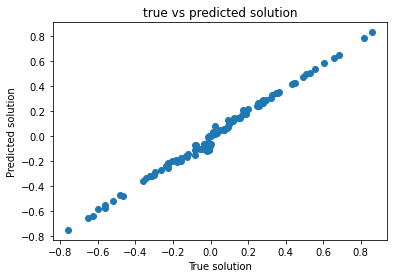

In [143]:
plt.scatter(Y_test_true,Y_test)
plt.title("true vs predicted solution")
plt.xlabel("True solution")
plt.ylabel("Predicted solution")
plt.show()

NameError: name 'cm' is not defined

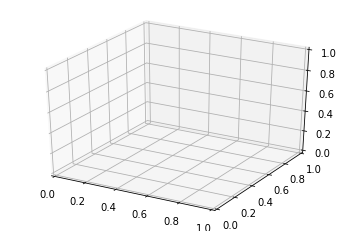

In [144]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
R = X**2 + Y**2
# Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, R, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
